In [1]:
from tqdm import tqdm
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import StepLR

# импортирую свои модули
import os
import sys
sys.path.append(os.path.abspath('..'))
from figures.plots import show_embeddings
from src.models import RepeatAutoencoder, BidirectionalAutoencoder
from src.loss import BidirectionalMSELoss
from data.dataloading import load_dataset, SequenceLengthSampler, pad_collate, load_dataset2

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
dataset = load_dataset2()

train_len = int(0.8 * len(dataset))
test_len = len(dataset) - train_len
train_dataset, test_dataset = random_split(dataset, lengths=[train_len, test_len])

bucket_boundaries = [2, 4, 6, 7, 10, 15, 20, 30, 40, 60, 80, 100]
lengths = [(i, len(item)) for i, item in enumerate(train_dataset)]
sampler = SequenceLengthSampler(lengths, bucket_boundaries, batch_size=16)

dataloader = DataLoader(train_dataset, collate_fn=pad_collate, batch_sampler=sampler)

In [3]:
model = RepeatAutoencoder(3, 16, 3)

In [4]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.8)

In [5]:
def validate(model, val_data, criterion):
    model.eval()
    loss_history = []
    for i, x in enumerate(val_data):
        x = x.unsqueeze(0)
        output = model(x)
        loss = criterion(output, x).item()
        loss_history.append(loss)
    return np.mean(loss_history)

In [6]:
train_history = []
val_history = []

for epoch in range(50):
    accumulated_loss = []
    for i, x in enumerate(dataloader):
        model.train()
        output = model(x)
        loss = criterion(output, x)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        accumulated_loss.append(loss.item())
    
    train_loss = np.mean(accumulated_loss)
    val_loss = validate(model, test_dataset, criterion)
    
    # if val_loss < val_history[-1]:
    #     torch.save(model.state_dict(), '../src/weights/pa.pth')
    
    train_history.append(train_loss)
    val_history.append(val_loss)
    
    print(f'Train loss: {train_loss}, Val loss: {val_loss}, epoch: {epoch}')
    
    scheduler.step()

Train loss: 0.15700489788344413, Val loss: 0.08100607420511967, epoch: 0
Train loss: 0.06901374791720599, Val loss: 0.021648958283893998, epoch: 1
Train loss: 0.03716675513000651, Val loss: 0.013531626500586405, epoch: 2
Train loss: 0.03166590312947378, Val loss: 0.011368450929744898, epoch: 3
Train loss: 0.02902965133755722, Val loss: 0.010593727393048332, epoch: 4
Train loss: 0.02656839850330443, Val loss: 0.009275440949127068, epoch: 5
Train loss: 0.02421487512730175, Val loss: 0.008848326988793155, epoch: 6
Train loss: 0.022640678625567956, Val loss: 0.008046299119088378, epoch: 7
Train loss: 0.02219037841899659, Val loss: 0.007725409189007586, epoch: 8
Train loss: 0.021618978224807617, Val loss: 0.007271932600070394, epoch: 9
Train loss: 0.020989540279984023, Val loss: 0.007046428984054097, epoch: 10
Train loss: 0.020168603067356867, Val loss: 0.006843562987026472, epoch: 11
Train loss: 0.020041279600947304, Val loss: 0.0066786358239785595, epoch: 12
Train loss: 0.0193611683077037

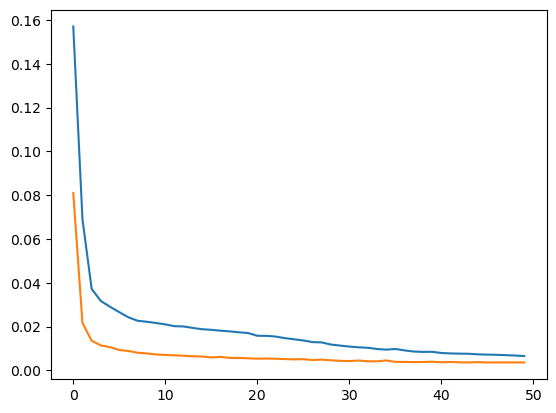

In [7]:
plt.plot(train_history)
plt.plot(val_history)

In [29]:
# torch.save(model.state_dict(), '../src/weights/pa.pth')

In [29]:
x = test_dataset[23].unsqueeze(0)
output = model(x)

In [30]:
x

tensor([[[ 0.1333,  0.0536,  0.0650],
         [ 0.1333,  0.0434,  0.0675],
         [ 0.1333,  0.0578,  0.0829],
         [ 0.1333,  0.0555,  0.0912],
         [ 0.1333,  0.0446,  0.0858],
         [ 0.1000,  0.0456,  0.0683],
         [ 0.1000,  0.0575,  0.0321],
         [ 0.1000,  0.0580,  0.0746],
         [ 0.1000,  0.0436,  0.0200],
         [ 0.0333,  0.0463,  0.0500],
         [ 0.0333,  0.0452,  0.0558],
         [ 0.7333,  0.0491,  0.0433],
         [ 0.0333,  0.0597,  0.0333],
         [ 0.0333,  0.0601,  0.0287],
         [ 1.4000,  0.0460, -0.0017],
         [ 0.0667,  0.0474, -0.0067]]])

In [31]:
output

tensor([[[0.1833, 0.0276, 0.0013],
         [0.1706, 0.0593, 0.0071],
         [0.2234, 0.0561, 0.0087],
         [0.2442, 0.0548, 0.0118],
         [0.2531, 0.0528, 0.0132],
         [0.2579, 0.0516, 0.0137],
         [0.2625, 0.0508, 0.0137],
         [0.2673, 0.0502, 0.0136],
         [0.2723, 0.0498, 0.0136],
         [0.2771, 0.0493, 0.0138],
         [0.2814, 0.0489, 0.0140],
         [0.2851, 0.0485, 0.0143],
         [0.2881, 0.0482, 0.0146],
         [0.2906, 0.0479, 0.0148],
         [0.2925, 0.0476, 0.0151],
         [0.2939, 0.0474, 0.0153]]], grad_fn=<ViewBackward0>)

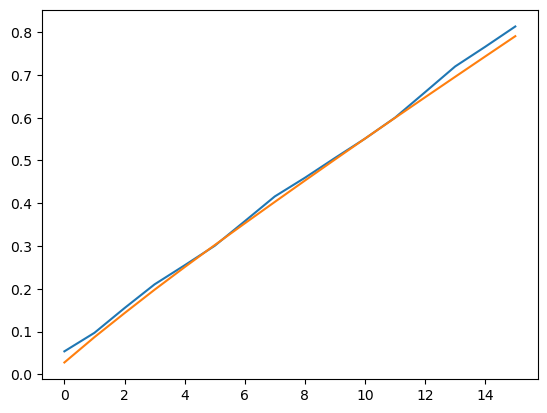

In [34]:
plt.plot(np.cumsum(x[0, :, 1].numpy()))
plt.plot(np.cumsum(output[0, :, 1].detach().numpy()))

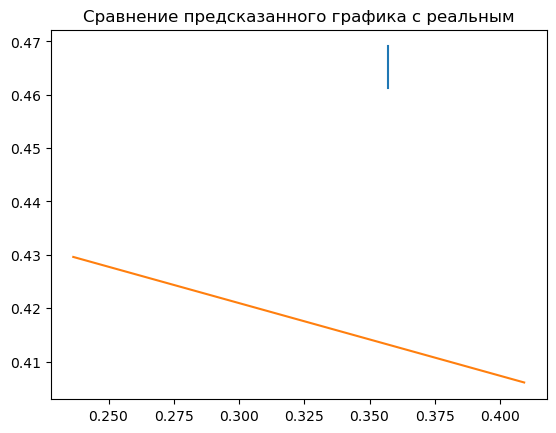

In [9]:
plt.title('Сравнение предсказанного графика с реальным')
i = 0
plt.plot(x[i, :, 0], x[i, :, 1])
plt.plot(output[i, :, 0].detach(), output[i, :, 1].detach())
# plt.savefig('../figures/supplier_spec_history.jpg', bbox_inches='tight')

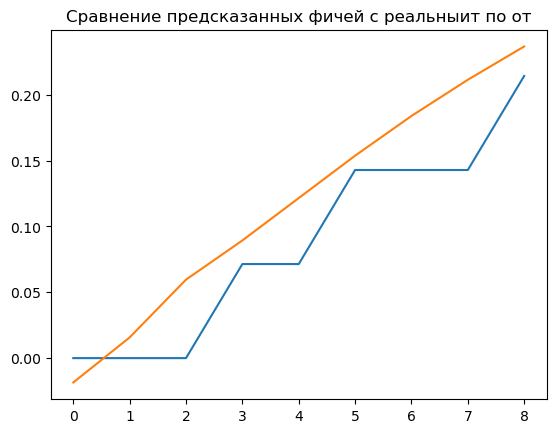

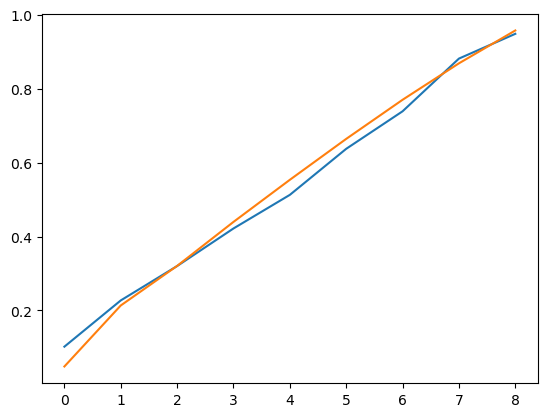

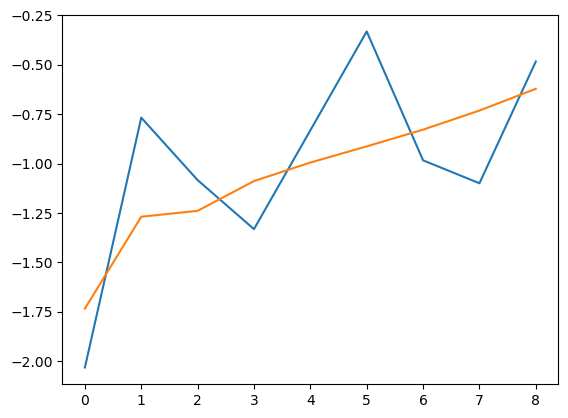

In [16]:
plt.title('Сравнение предсказанных фичей с реальныит по от')
i = 0
for feature in range(3):
    plt.plot(x[i, :, feature])
    plt.plot(output[i, :, feature].detach())
    plt.show()

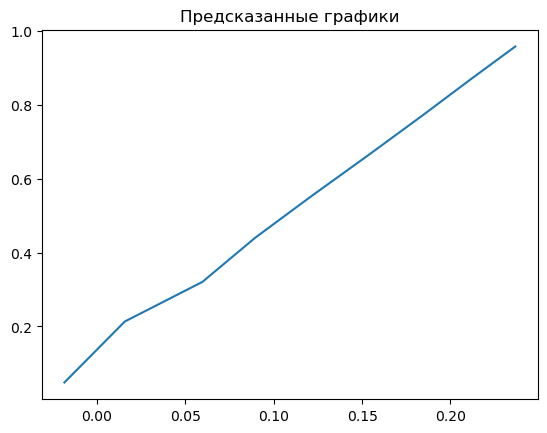

In [21]:
plt.title('Предсказанные графики')
for i in range(output.shape[0]):
    plt.plot(output[i, :, 0].detach(), output[i, :, 1].detach())

In [22]:
supplier_set = set(dataset.supplier[30:45])

indexes = np.where([
    (supplier in supplier_set) for supplier in dataset.supplier
])[0]

In [33]:
seqs = [dataset[i] for i in indexes]
suppliers = [dataset.supplier[i] for i in indexes]
embs = np.stack([model.encoder(seq.unsqueeze(0))[1][0].squeeze().detach().numpy() for seq in seqs])

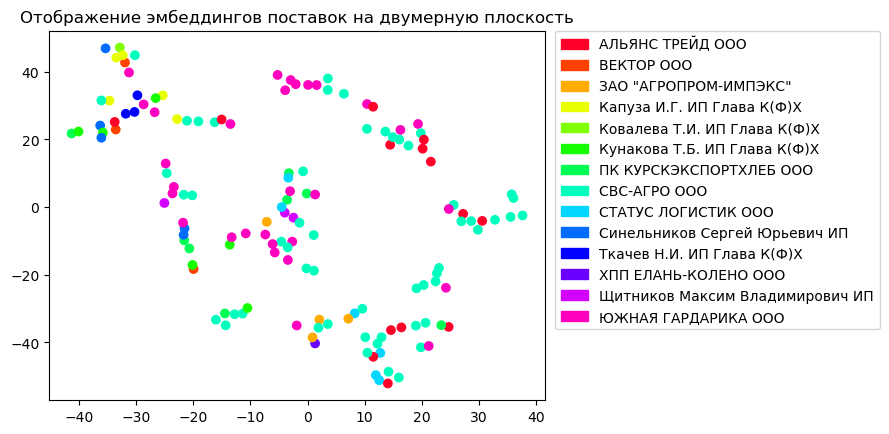

In [34]:
plt.title('Отображение эмбеддингов поставок на двумерную плоскость')
show_embeddings(embs, suppliers)
# plt.savefig('../figures/tsne_spec_embedings.jpg', bbox_inches='tight')

In [22]:
"""
Собираем датасет с эмбеддингами поставок
"""

embed_df = pd.DataFrame(columns = ['id', 'supplier', 'date'] +
                        [f'{i}' for i in range(model.hidden_dim)])
for i, x in tqdm(enumerate(dataset)):
    embed = model.encoder(x.unsqueeze(0))[1][0]
    
    embed = embed[0, -1].detach().tolist()
    spec_data = [dataset.specs[i], dataset.supplier[i], dataset.specs_date[i]]
    
    embed_df.loc[len(embed_df)] = spec_data + embed

3428it [00:27, 126.32it/s]


In [23]:
embed_df.to_csv('../data/processed_data/embed_df2.csv', index=False)

In [24]:
embed_df.head(2)

,id,supplier,date,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,Рязанова А.В. ИП Глава К(Ф)Х_ЮР Валуйский МЭЗ ...,Рязанова А.В. ИП Глава К(Ф)Х,2022-07-09,0.179263,0.397424,0.113221,-0.111528,0.366467,-0.381033,0.254327,0.100963,-0.170762,-0.172413,-0.291943,-0.198528,-0.229292,-0.142300,-0.273950,-0.274509
1,"Осипов Л.А. ИП Глава К(Ф)Х_Юг Руси, АО_2022-07-12",Осипов Л.А. ИП Глава К(Ф)Х,2022-07-22,0.245517,0.419569,-0.068546,-0.844470,0.496504,0.031048,0.583373,0.637543,-0.203895,-0.110696,-0.028294,-0.317550,-0.299834,-0.378731,0.556121,-0.330221
